# <center> Trabajo Practico N2: Redes Recurrentes para Multilabel Classification with NLP </center>
<div>
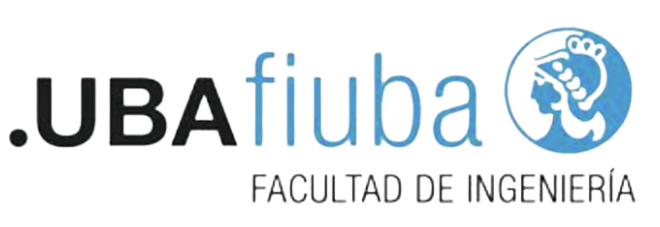
</div>

### <center>José Mornaghi y Lucas Argento</center>

## Predicción de dominio a partir de un título de un ítem en e-commerce

A partir de un dataset de productos de MercadoLibre, buscaremos utilizar RNNs para clasificar el domain del item. 
La idea es que los vendedores publiciten su producto definiendo caracteristicas y modelo en texto, y nuestra red sea capaz de clasificarlo en base a frecuencia, cercania de palabras, etc.

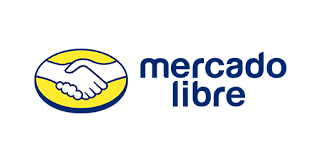


El proposito de este proyecto es entender el funcionamiento de las Redes Recurrentes.

> **Para poder realizar este trabajo, es necesario comprender sobre Natural Language Processing, que nos va a permitir lidiar con strings y la conversion a un sistema que nuestras redes sean capaces de entender.**

#### Librerias

In [13]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import time

import torchtext
from torchmetrics import F1Score
from torchmetrics.classification import BinaryF1Score
from torchtext.data.utils import get_tokenizer
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from sklearn.metrics import mean_squared_error
from torchtext.vocab import Vocab
import spacy
# python -m spacy download es
from collections import Counter
from sklearn.model_selection import train_test_split

In [51]:
RANDOM_SEED=42 # try changing this to different values and see what happens to the numbers below
torch.manual_seed(seed=RANDOM_SEED)

> Links utiles

https://youtu.be/KRgq4VnCr7I

https://docs.aws.amazon.com/sagemaker/latest/dg/sms-text-classification-multilabel.html

https://towardsdatascience.com/multiclass-text-classification-using-lstm-in-pytorch-eac56baed8df

https://h-huang.github.io/tutorials/beginner/text_sentiment_ngrams_tutorial.html

http://www.cse.chalmers.se/~richajo/nlp2019/l4/Text%20classification%20using%20RNNs.html

https://towardsdatascience.com/what-is-embedding-and-what-can-you-do-with-it-61ba7c05efd8

#### DataFrame

In [52]:
dfMELI = pd.read_csv('Datasets/items_meli_proccess.csv', engine = 'python',delimiter = '␗')
dfMELI

,id,site_id,title,category_id,domain_id
0,MLA915976815,MLA,samsung galaxy a02 32 gb negro 2 gb ram,MLA1055,MLA-CELLPHONES
1,MLA1105441801,MLA,samsung galaxy a12 64 gb azul 4 gb ram,MLA1055,MLA-CELLPHONES
2,MLA1112715843,MLA,alcatel 3h 64 gb elegant black 3 gb ram,MLA1055,MLA-CELLPHONES
3,MLA929295024,MLA,moto e7 32 gb azul aqua 2 gb ram,MLA1055,MLA-CELLPHONES
4,MLA1106901282,MLA,ipro a20 dual sim 32 mb negro 32 mb ram,MLA1055,MLA-CELLPHONES
...,...,...,...,...,...
7475,MLA1112681178,MLA,audi q8 55 tfsi tiptronic quattro 340cv 2020 ...,MLA1744,MLA-CARS_AND_VANS
7476,MLA1112750522,MLA,audi q8 55 tfsi tiptronic quattro 2021 0km sin...,MLA1744,MLA-CARS_AND_VANS
7477,MLA1112719885,MLA,audi q5 2 0t fsi quattro taraborelli usados sa...,MLA1744,MLA-CARS_AND_VANS
7478,MLA1112750313,MLA,audi a6 allroad 55 tfsi quattro 340cv mild hyb...,MLA1744,MLA-CARS_AND_VANS


Conservamos las columnas relevantes y calculamos la longitud de las secuencias

In [53]:
dfMELI = dfMELI[['title', 'domain_id']]
dfMELI.columns = ['title', 'domain_id']
dfMELI['title_length'] = dfMELI['title'].apply(lambda x: len(x.split()))
dfMELI

C:\Users\Jose\AppData\Local\Temp\ipykernel_25972\156700188.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfMELI['title_length'] = dfMELI['title'].apply(lambda x: len(x.split()))


,title,domain_id,title_length
0,samsung galaxy a02 32 gb negro 2 gb ram,MLA-CELLPHONES,9
1,samsung galaxy a12 64 gb azul 4 gb ram,MLA-CELLPHONES,9
2,alcatel 3h 64 gb elegant black 3 gb ram,MLA-CELLPHONES,9
3,moto e7 32 gb azul aqua 2 gb ram,MLA-CELLPHONES,9
4,ipro a20 dual sim 32 mb negro 32 mb ram,MLA-CELLPHONES,10
...,...,...,...
7475,audi q8 55 tfsi tiptronic quattro 340cv 2020 ...,MLA-CARS_AND_VANS,9
7476,audi q8 55 tfsi tiptronic quattro 2021 0km sin...,MLA-CARS_AND_VANS,11
7477,audi q5 2 0t fsi quattro taraborelli usados sa...,MLA-CARS_AND_VANS,10
7478,audi a6 allroad 55 tfsi quattro 340cv mild hyb...,MLA-CARS_AND_VANS,10


Calculamos la longitud media del titulo para despues usarla en el encoding

In [54]:
np.mean(dfMELI['title_length'])

9.045454545454545

## El proceso de preprocessing for NLP implica:

**Tokenizar:** se define el metodo de como separar las palabras dentro un texto. Se elige el espacio, una coma, un numero?\
En nuestro caso el espacio separa las palabras

In [55]:
nlp = spacy.load("es_core_news_sm")
def tokenize(text):
    return [token.text for token in nlp.tokenizer(text)]

Realizamos un conteo de cuantas veces se utiliza cada palabra

In [56]:
# Contador
counts = Counter()
for index, row in dfMELI.iterrows():
    counts.update(tokenize(row['title']))

Borramos las palabras con frecuencia menor a 2 en todo el dataset.\
La logica es que dada su baja frecuencia, no son indicativas para ayudarnos a clasificar.

In [57]:
#deleting infrequent words
print("num_words before:",len(counts.keys()))
for word in list(counts):
    if counts[word] < 2:
        del counts[word]
print("num_words after:",len(counts.keys()))

num_words before: 795
num_words after: 779


> **Creamos el vocabulario.**

Consiste en armar un array que contenga todas y cada una de las palabras/digitos o caracteres en la columna titulo.

In [58]:
vocab2index = {"":0, "UNK":1}
words = ["", "UNK"]
for word in counts:
    vocab2index[word] = len(words)
    words.append(word)
print(vocab2index)

{'': 0, 'UNK': 1, 'samsung': 2, 'galaxy': 3, 'a02': 4, '32': 5, 'gb': 6, 'negro': 7, '2': 8, 'ram': 9, 'a12': 10, '64': 11, 'azul': 12, '4': 13, 'alcatel': 14, '3h': 15, 'elegant': 16, 'black': 17, '3': 18, 'moto': 19, 'e7': 20, 'aqua': 21, 'ipro': 22, 'a20': 23, 'dual': 24, 'sim': 25, 'mb': 26, 'quantum': 27, 'five': 28, 'oro': 29, '512': 30, 'a32': 31, '128': 32, 'awesome': 33, 'nokia': 34, '106': 35, ' ': 36, '2018': 37, 'gris': 38, 'oscuro': 39, '24': 40, 'm': 41, 'carbon': 42, 'a01': 43, 'core': 44, '16': 45, '1': 46, 'kodak': 47, 'smartway': 48, 'l1': 49, 'pro': 50, 'g20': 51, 'cielo': 52, 'tcl': 53, 'l7': 54, '10': 55, 'se': 56, 'polar': 57, 'night': 58, 'zte': 59, 'blade': 60, 'a3': 61, '2020': 62, 'lg': 63, 'k61': 64, 'titanio': 65, 'k22': 66, 'titan': 67, 'k41s': 68, 'blue': 69, 'f1': 70, 'rosa': 71, 'celular': 72, 'libre': 73, '1l': 74, 'open': 75, 'techcel': 76, 'nuevo': 77, 'm12': 78, '5000': 79, 'mah': 80, 'a03s': 81, 'k52': 82, '48': 83, 'mpx': 84, 'motorola': 85, 'edge'

**Escribimos una funcion que nos permite tokenizar y encodear una frase.**

Primero tokenizamos el texto.\
Encodeamos convirtiendo cada palabra en un integer y generando un vocabulario.\
Calculamos la longitud de la frase asi podemos luego usarlo como referencia para saber en promedio cuantas palabras componen la frase.

In [59]:
def encode_sentence(text, vocab2index, N=9):
    tokenized = tokenize(text)
    encoded = np.zeros(N, dtype=int)
    enc1 = np.array([vocab2index.get(word, vocab2index["UNK"]) for word in tokenized])
    length = min(N, len(enc1))
    encoded[:length] = enc1[:length]
    return encoded, length

In [60]:
dfMELI['encoded'] = dfMELI['title'].apply(lambda x: np.array(encode_sentence(x,vocab2index )))
dfMELI

C:\Users\Jose\AppData\Local\Temp\ipykernel_25972\26079795.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dfMELI['encoded'] = dfMELI['title'].apply(lambda x: np.array(encode_sentence(x,vocab2index )))
C:\Users\Jose\AppData\Local\Temp\ipykernel_25972\26079795.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfMELI['encoded'] = dfMELI['title'].apply(lambda x: np.array(encode_sentence(x,vocab2index )))


,title,domain_id,title_length,encoded
0,samsung galaxy a02 32 gb negro 2 gb ram,MLA-CELLPHONES,9,"[[2, 3, 4, 5, 6, 7, 8, 6, 9], 9]"
1,samsung galaxy a12 64 gb azul 4 gb ram,MLA-CELLPHONES,9,"[[2, 3, 10, 11, 6, 12, 13, 6, 9], 9]"
2,alcatel 3h 64 gb elegant black 3 gb ram,MLA-CELLPHONES,9,"[[14, 15, 11, 6, 16, 17, 18, 6, 9], 9]"
3,moto e7 32 gb azul aqua 2 gb ram,MLA-CELLPHONES,9,"[[19, 20, 5, 6, 12, 21, 8, 6, 9], 9]"
4,ipro a20 dual sim 32 mb negro 32 mb ram,MLA-CELLPHONES,10,"[[22, 23, 24, 25, 5, 26, 7, 5, 26], 9]"
...,...,...,...,...
7475,audi q8 55 tfsi tiptronic quattro 340cv 2020 ...,MLA-CARS_AND_VANS,9,"[[723, 731, 333, 768, 624, 769, 770, 62, 110], 9]"
7476,audi q8 55 tfsi tiptronic quattro 2021 0km sin...,MLA-CARS_AND_VANS,11,"[[723, 731, 333, 768, 624, 769, 603, 583, 613]..."
7477,audi q5 2 0t fsi quattro taraborelli usados sa...,MLA-CARS_AND_VANS,10,"[[723, 729, 8, 583, 773, 774, 769, 775, 776], 9]"
7478,audi a6 allroad 55 tfsi quattro 340cv mild hyb...,MLA-CARS_AND_VANS,10,"[[723, 733, 778, 333, 768, 769, 770, 779, 780]..."


In [61]:
# Definimos las categorias y las numerizamos.
categorias = {'MLA-CELLPHONES':0, 'MLA-CELL_BATTERIES':1, 'MLA-SPEAKERS':2, 'MLA-HEADPHONES':3}
categorias

{'MLA-CELLPHONES': 0,
 'MLA-CELL_BATTERIES': 1,
 'MLA-SPEAKERS': 2,
 'MLA-HEADPHONES': 3}

In [62]:
# Manipulamos el dataframe para reemplazar los strings de categorias por sus correspondientes valores.
dfMELI = dfMELI.replace({'domain_id':categorias})
dfMELI['domain_id'].unique()

array([0, 1, 2, 3, 'MLA-POWER_CORDS', 'MLA-STREAMING_MEDIA_DEVICES',
       'MLA-SMART_SPEAKERS', 'MLA-AUDIO_AND_VIDEO_CABLES_AND_ADAPTERS',
       'MLA-LED_CHIPS', 'MLA-TV_AND_MONITOR_MOUNTS',
       'MLA-MICROPHONE_STANDS', 'MLA-ALARM_CLOCKS',
       'MLA-ELECTRONIC_PRODUCTS', 'MLA-MICROPHONES', 'MLA-TELEVISIONS',
       'MLA-TV_RECEIVERS_AND_DECODERS',
       'MLA-TV_REPLACEMENT_BACKLIGHT_LED_STRIPS',
       'MLA-TV_REMOTE_CONTROLS', 'MLA-AM_FM_RADIOS', 'MLA-CARS_AND_VANS'],
      dtype=object)

In [63]:
dfMELI

,title,domain_id,title_length,encoded
0,samsung galaxy a02 32 gb negro 2 gb ram,0,9,"[[2, 3, 4, 5, 6, 7, 8, 6, 9], 9]"
1,samsung galaxy a12 64 gb azul 4 gb ram,0,9,"[[2, 3, 10, 11, 6, 12, 13, 6, 9], 9]"
2,alcatel 3h 64 gb elegant black 3 gb ram,0,9,"[[14, 15, 11, 6, 16, 17, 18, 6, 9], 9]"
3,moto e7 32 gb azul aqua 2 gb ram,0,9,"[[19, 20, 5, 6, 12, 21, 8, 6, 9], 9]"
4,ipro a20 dual sim 32 mb negro 32 mb ram,0,10,"[[22, 23, 24, 25, 5, 26, 7, 5, 26], 9]"
...,...,...,...,...
7475,audi q8 55 tfsi tiptronic quattro 340cv 2020 ...,MLA-CARS_AND_VANS,9,"[[723, 731, 333, 768, 624, 769, 770, 62, 110], 9]"
7476,audi q8 55 tfsi tiptronic quattro 2021 0km sin...,MLA-CARS_AND_VANS,11,"[[723, 731, 333, 768, 624, 769, 603, 583, 613]..."
7477,audi q5 2 0t fsi quattro taraborelli usados sa...,MLA-CARS_AND_VANS,10,"[[723, 729, 8, 583, 773, 774, 769, 775, 776], 9]"
7478,audi a6 allroad 55 tfsi quattro 340cv mild hyb...,MLA-CARS_AND_VANS,10,"[[723, 733, 778, 333, 768, 769, 770, 779, 780]..."


> Dropear todos los rows que tengan un string en domain id. Conservamos los integers que son las cuatro clases que vamos a utilizar a lo largo del trabajo de clasificacion.

In [64]:
dfMELI = dfMELI[dfMELI['domain_id'].astype(str).str.isdigit()]
dfMELI

,title,domain_id,title_length,encoded
0,samsung galaxy a02 32 gb negro 2 gb ram,0,9,"[[2, 3, 4, 5, 6, 7, 8, 6, 9], 9]"
1,samsung galaxy a12 64 gb azul 4 gb ram,0,9,"[[2, 3, 10, 11, 6, 12, 13, 6, 9], 9]"
2,alcatel 3h 64 gb elegant black 3 gb ram,0,9,"[[14, 15, 11, 6, 16, 17, 18, 6, 9], 9]"
3,moto e7 32 gb azul aqua 2 gb ram,0,9,"[[19, 20, 5, 6, 12, 21, 8, 6, 9], 9]"
4,ipro a20 dual sim 32 mb negro 32 mb ram,0,10,"[[22, 23, 24, 25, 5, 26, 7, 5, 26], 9]"
...,...,...,...,...
4971,auriculares philips shl5005 blanco,3,4,"[[229, 458, 549, 143, 0, 0, 0, 0, 0], 4]"
4972,pila carbon zinc aa motoma caja x 60 unids ...,1,18,"[[442, 42, 550, 258, 551, 552, 213, 212, 553], 9]"
4974,parlante philips tanx50 con bluetooth negro 10...,2,8,"[[221, 458, 566, 226, 195, 7, 567, 286, 0], 8]"
4975,pila aaa energizer max e92 cilindrica pack d...,1,10,"[[442, 209, 89, 568, 569, 446, 110, 447, 207], 9]"


## Clasificacion Binaria entre dos clases de Domain_id

> Elegimos clasificar a que clase pertenece en base a la informacion contenida en title:
> * Cellphones
> * Cell Batteries

In [65]:
dfMELI_2_clases = dfMELI[dfMELI.domain_id.isin([0, 1])].reset_index(drop=True)
dfMELI_2_clases

,title,domain_id,title_length,encoded
0,samsung galaxy a02 32 gb negro 2 gb ram,0,9,"[[2, 3, 4, 5, 6, 7, 8, 6, 9], 9]"
1,samsung galaxy a12 64 gb azul 4 gb ram,0,9,"[[2, 3, 10, 11, 6, 12, 13, 6, 9], 9]"
2,alcatel 3h 64 gb elegant black 3 gb ram,0,9,"[[14, 15, 11, 6, 16, 17, 18, 6, 9], 9]"
3,moto e7 32 gb azul aqua 2 gb ram,0,9,"[[19, 20, 5, 6, 12, 21, 8, 6, 9], 9]"
4,ipro a20 dual sim 32 mb negro 32 mb ram,0,10,"[[22, 23, 24, 25, 5, 26, 7, 5, 26], 9]"
...,...,...,...,...
2620,blister 4 pilas aa recargables scp 2700 mah,1,8,"[[435, 13, 208, 258, 210, 211, 436, 80, 0], 8]"
2621,pila aa energizer recharge nh15 2000 cilindric...,1,11,"[[442, 258, 89, 443, 444, 445, 446, 110, 447], 9]"
2622,pila 2032 5 unidades maxell,1,5,"[[442, 544, 149, 448, 545, 0, 0, 0, 0], 5]"
2623,pila carbon zinc aa motoma caja x 60 unids ...,1,18,"[[442, 42, 550, 258, 551, 552, 213, 212, 553], 9]"


In [66]:
Counter(dfMELI_2_clases['domain_id'])

Counter({0: 2500, 1: 125})

### Split del dataset en entrenamiento/test/valid.

> Data split para clasificacion de dos clases

In [67]:
x = list(dfMELI_2_clases['encoded'])
y = list(dfMELI_2_clases['domain_id'])

x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(x, y, test_size=0.2 )

In [68]:
class MELIdataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return torch.from_numpy(self.x[idx][0].astype(np.int32)), self.y[idx], self.x[idx][1]

In [69]:
train_ds = MELIdataset(x_train_2, y_train_2)
test_ds = MELIdataset(x_test_2, y_test_2)

In [70]:
def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

def train_model(model, epochs=10, lr=0.001):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.Adam(parameters, lr=lr)
    criterion = nn.BCEWithLogitsLoss()
    loss_values = []
    for i in range(epochs):
        model.train()
        sum_loss = 0.0
        total = 0
        for x, y, l in train_dl:
            #x = x.long()
            y = y.float()
            y_pred = model(x, l)
            y_pred =  torch.squeeze(y_pred)
            optimizer.zero_grad()
            loss = criterion(y_pred, y)
            loss_values.append(loss.detach().numpy())
            loss.backward()
            optimizer.step()
            sum_loss += loss.item()*y.shape[0]
            # item() method extracts the loss’s value as a Python float
            total += y.shape[0]
        print("train loss %.3f" % (sum_loss/total))
        accuracy = binary_accuracy(y_pred, y)
        print("Accuracy", accuracy)
        f1 = BinaryF1Score()
        print("F1 Score: ", f1(y_pred, y))
    return loss_values

def validation_metrics (model, test_dl):
    model.eval()
    correct = 0
    total = 0
    sum_loss = 0.0
    sum_rmse = 0.0
    for x, y, l in test_dl:
        #x = x.long()
        y = y.float()
        y_pred = model(x, l)
        y_pred =  torch.squeeze(y_pred)
        y_posta = y
    acc = binary_accuracy(y_pred, y_posta)
    print("Test ACC: ", acc)
    f1 = BinaryF1Score()
    print("Test F1 Score: ", f1(y_pred, y_posta))

In [71]:
batch_size = 500
vocab_size = len(words)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size)

In [72]:
class LSTM_variable_input(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim) :
        super().__init__()
        self.hidden_dim = hidden_dim
        self.dropout = nn.Dropout(0.3)
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        
    def forward(self, x, s):
        x = self.embeddings(x)
        x = self.dropout(x)
        x_pack = pack_padded_sequence(x, s, batch_first=True, enforce_sorted=False)
        out_pack, (ht, ct) = self.lstm(x_pack)
        out = self.linear(ht[-1])
        return out

Despues de definir el modelo, como entrenarlo, como medir la performance, la clase LSTM y su estructura, procedemos a aplicar el entrenamiento.

In [73]:
model = LSTM_variable_input(vocab_size, 100, 256)

Calculamos las metricas de nuestro modelo.\
El Loss value, la Accuracy (no es realmente indicativo debido a la skewness) y el F1 Score.

In [74]:
loss_vals = train_model(model, epochs=100, lr=0.001)

train loss 0.562
Accuracy tensor(0.9700)
F1 Score:  tensor(0.5714)
train loss 0.245
Accuracy tensor(0.9800)
F1 Score:  tensor(0.5000)
train loss 0.079
Accuracy tensor(0.9600)
F1 Score:  tensor(0.)
train loss 0.041
Accuracy tensor(0.9900)
F1 Score:  tensor(0.8571)
train loss 0.021
Accuracy tensor(0.9900)
F1 Score:  tensor(0.9474)
train loss 0.014
Accuracy tensor(1.)
F1 Score:  tensor(1.)
train loss 0.011
Accuracy tensor(1.)
F1 Score:  tensor(1.)
train loss 0.009
Accuracy tensor(1.)
F1 Score:  tensor(1.)
train loss 0.007
Accuracy tensor(1.)
F1 Score:  tensor(1.)
train loss 0.005
Accuracy tensor(1.)
F1 Score:  tensor(1.)
train loss 0.004
Accuracy tensor(1.)
F1 Score:  tensor(1.)
train loss 0.002
Accuracy tensor(1.)
F1 Score:  tensor(1.)
train loss 0.002
Accuracy tensor(1.)
F1 Score:  tensor(1.)
train loss 0.001
Accuracy tensor(1.)
F1 Score:  tensor(1.)
train loss 0.001
Accuracy tensor(1.)
F1 Score:  tensor(1.)
train loss 0.002
Accuracy tensor(1.)
F1 Score:  tensor(1.)
train loss 0.001
Acc

### Dibujamos la curva de la funcion de costo de Train

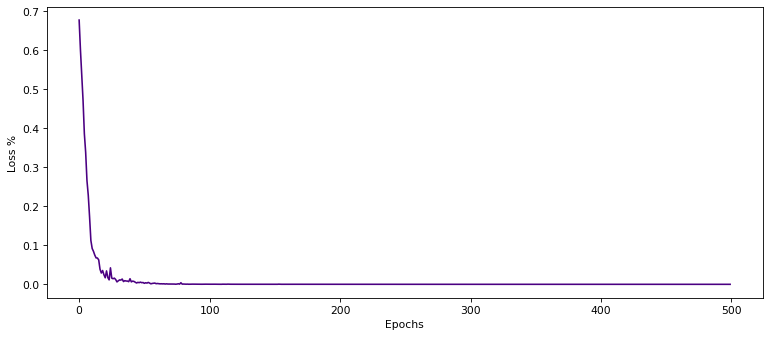

In [75]:
plt.figure(figsize=(12,5), dpi= 77)
plt.xlabel("Epochs")
plt.ylabel("Loss %")

plt.plot(loss_vals, color = 'indigo')
plt.show()

In [76]:
validation_metrics(model, test_dl)

Test ACC:  tensor(1.)
Test F1 Score:  tensor(1.)


> Nuestro primer modelo obtiene un **F1 Score de 1** cuando lo verificamos contra el test set.\
Puede ser indicativo de una gran capacidad de prediccion de la red, o de un overfitting.

### Variamos dos parámetros de la red para analizar el comportamiento y entender en que afecta la capacidad de prediccion.

> Elegimos modificar:
> * Embedding dimension: lo redujimos haciendo mas pequeno el espacio de representacion de la data.
> * Hidden dimension: aumentamos el valor para impactar en la recurrencia de la red.


In [77]:
model2 = LSTM_variable_input(vocab_size, 50, 512)

In [78]:
loss_vals2 = train_model(model2, epochs=100, lr=0.001)

train loss 0.532
Accuracy tensor(0.9500)
F1 Score:  tensor(0.)
train loss 0.147
Accuracy tensor(0.9500)
F1 Score:  tensor(0.)
train loss 0.053
Accuracy tensor(1.)
F1 Score:  tensor(1.)
train loss 0.027
Accuracy tensor(1.)
F1 Score:  tensor(1.)
train loss 0.018
Accuracy tensor(1.)
F1 Score:  tensor(1.)
train loss 0.010
Accuracy tensor(1.)
F1 Score:  tensor(1.)
train loss 0.004
Accuracy tensor(1.)
F1 Score:  tensor(1.)
train loss 0.003
Accuracy tensor(1.)
F1 Score:  tensor(1.)
train loss 0.001
Accuracy tensor(1.)
F1 Score:  tensor(1.)
train loss 0.000
Accuracy tensor(1.)
F1 Score:  tensor(1.)
train loss 0.000
Accuracy tensor(1.)
F1 Score:  tensor(1.)
train loss 0.000
Accuracy tensor(1.)
F1 Score:  tensor(1.)
train loss 0.000
Accuracy tensor(1.)
F1 Score:  tensor(1.)
train loss 0.000
Accuracy tensor(1.)
F1 Score:  tensor(1.)
train loss 0.000
Accuracy tensor(1.)
F1 Score:  tensor(1.)
train loss 0.000
Accuracy tensor(1.)
F1 Score:  tensor(1.)
train loss 0.000
Accuracy tensor(1.)
F1 Score:  

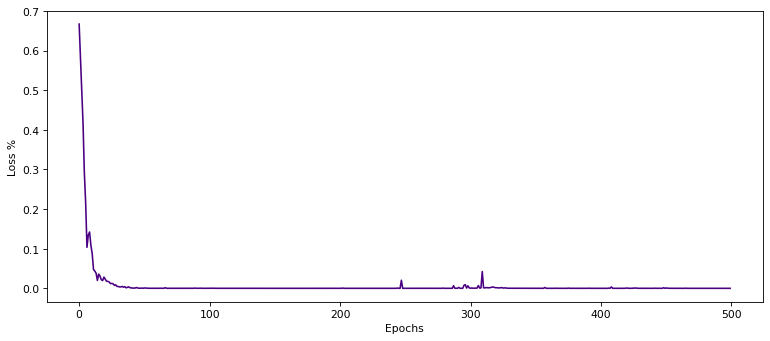

In [81]:
plt.figure(figsize=(12,5), dpi= 77)
plt.xlabel("Epochs")
plt.ylabel("Loss %")

plt.plot(loss_vals2, color = 'indigo')
plt.show()

In [82]:
validation_metrics(model2, test_dl)

Test ACC:  tensor(1.)
Test F1 Score:  tensor(1.)


> Aun variando valores de la red, el F1 Score continua en 1.

### Métricas utilizaría para medir objetivamente la performance del modelo?

##### Realizamos un Counter para poder entender como se distribuye nuestras clases. Claramente hay una skewness que impide tomar objetivamente el accuracy como indicador.
Por eso utilizamos el **F1 Score** como indicador. Se calcula en base a la Precision y el Recall.

> **Recall**: Es la habilidad del modelo de encontrar todos los casos relevantes. Matematicamente, definimos recall como el numero de true positives, dividido por el number de True Positives mas el numero de False Negatives.\
> **Precision**: La habilidad del modelo de clasificacion para clasificar solo los data points relevantes.\ Matematicamente la precision representa el numero de True Positives dividido sobre True Positives mas el numbero de False Positives.\
> **F1 score**: Es la media armónica de precisión y el recall. Matematicamente es:\

F1 = 2 x Recall x Precision / Recall + Precision

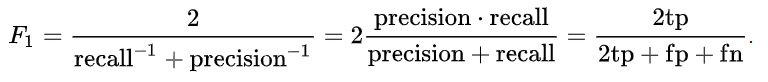

## Clasificacion entre cuatro clases de Domain_id

> Elegimos clasificar a que clase pertenece en base a la informacion contenida en title:
> * Cellphones
> * Cell Batteries
> * Speakers
> * Headphones

In [82]:
dfMELI_4_clases = dfMELI[dfMELI.domain_id.isin([0,1,2,3])].reset_index(drop=True)
dfMELI_4_clases

,title,domain_id,title_length,encoded
0,samsung galaxy a02 32 gb negro 2 gb ram,0,9,"[[2, 3, 4, 5, 6, 7, 8, 6, 9], 9]"
1,samsung galaxy a12 64 gb azul 4 gb ram,0,9,"[[2, 3, 10, 11, 6, 12, 13, 6, 9], 9]"
2,alcatel 3h 64 gb elegant black 3 gb ram,0,9,"[[14, 15, 11, 6, 16, 17, 18, 6, 9], 9]"
3,moto e7 32 gb azul aqua 2 gb ram,0,9,"[[19, 20, 5, 6, 12, 21, 8, 6, 9], 9]"
4,ipro a20 dual sim 32 mb negro 32 mb ram,0,10,"[[22, 23, 24, 25, 5, 26, 7, 5, 26], 9]"
...,...,...,...,...
3384,auriculares philips shl5005 blanco,3,4,"[[229, 458, 549, 143, 0, 0, 0, 0, 0], 4]"
3385,pila carbon zinc aa motoma caja x 60 unids ...,1,18,"[[442, 42, 550, 258, 551, 552, 213, 212, 553], 9]"
3386,parlante philips tanx50 con bluetooth negro 10...,2,8,"[[221, 458, 566, 226, 195, 7, 567, 286, 0], 8]"
3387,pila aaa energizer max e92 cilindrica pack d...,1,10,"[[442, 209, 89, 568, 569, 446, 110, 447, 207], 9]"


In [83]:
Counter(dfMELI_4_clases['domain_id'])

Counter({0: 2500, 1: 125, 2: 278, 3: 486})

In [129]:
x4 = list(dfMELI_4_clases['encoded'])
y4 = list(dfMELI_4_clases['domain_id'])

x_train_4, x_test_4, y_train_4, y_test_4 = train_test_split(x4, y4, test_size=0.2) 

In [130]:
train_ds4 = MELIdataset(x_train_4, y_train_4)
test_ds4 = MELIdataset(x_test_4, y_test_4)

In [131]:
def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

def train_model4(model4, epochs=10, lr=0.001):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.Adam(parameters, lr=lr)
    criterion = nn.CrossEntropyLoss()
    loss_values4 = []
    for i in range(epochs):
        model4.train()
        sum_loss = 0.0
        total = 0
        for x, y, l in train_dl4:
            x = x.long()
            y = y.long()
            y_pred = model4(x, l)
            y_pred =  torch.squeeze(y_pred)
            print(y, y_pred,len(y),len(y_pred))
            optimizer.zero_grad()
            loss = criterion(y_pred, y)
            loss_values4.append(loss.detach().numpy())
            loss.backward()
            optimizer.step()
            sum_loss += loss.item()*y.shape[0]
            # item() method extracts the loss’s value as a Python float
            total += y.shape[0]
        # test_loss, test_acc, val_rmse = validation_metrics(model, val_dl)
        print("train loss %.3f" % (sum_loss/total))
        #accuracy = binary_accuracy(y_pred, y)
        #print("Accuracy", accuracy)
        #f1 = BinaryF1Score()
        #print("F1 Score: ", f1(y_pred, y))
    return loss_values4

def validation_metrics4(model4, test_dl4):
    model4.eval()
    correct = 0
    total = 0
    sum_loss = 0.0
    sum_rmse = 0.0
    for x, y, l in test_dl4:
        x = x.long()
        y = y.long()
        y_pred = model4(x, l)
        y_pred =  torch.squeeze(y_pred)
        y_posta = y
    #acc = binary_accuracy(y_pred, y_posta)
    #print("Test ACC: ", acc)
    #f1 = BinaryF1Score()
    #print("Test F1 Score: ", f1(y_pred, y_posta))

In [168]:
class LSTM_variable_input4(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim) :
        super().__init__()
        self.hidden_dim = hidden_dim
        self.dropout = nn.Dropout(0.3)
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, 256)
        self.fc2 = nn.Linear(256, 4)
        
    def forward(self, x, s):
        x = self.embeddings(x)
        x = self.dropout(x)
        x_pack = pack_padded_sequence(x, s, batch_first=True, enforce_sorted=False)
        out_pack, (ht, ct) = self.lstm(x_pack)
        out = self.fc1(ht[-1])
        sigmoid = nn.Sigmoid()
        out = sigmoid(out)
        out = self.fc2(out)
        return out

In [169]:
batch_size = 500
vocab_size = len(words)
train_dl4 = DataLoader(train_ds4, batch_size=batch_size, shuffle=True)
test_dl4 = DataLoader(test_ds4, batch_size=batch_size)

In [170]:
model4 = LSTM_variable_input4(vocab_size, 100, 512)

In [177]:
loss_vals4 = train_model4(model4, epochs=10, lr=0.1)

tensor([0, 0, 0, 2, 2, 0, 0, 3, 0, 3, 2, 0, 0, 0, 0, 0, 3, 0, 1, 0, 0, 0, 0, 0,
        0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0,
        3, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 3, 0, 0, 3, 0, 2, 0, 0, 3, 0, 0,
        0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 2, 0, 0,
        3, 0, 0, 0, 0, 0, 0, 3, 1, 0, 0, 3, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 3, 0, 2, 0, 3, 2, 0, 0, 3, 0, 0, 0, 0, 0, 3, 0, 3, 3, 2, 0, 0,
        0, 3, 3, 0, 2, 3, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0,
        3, 3, 0, 3, 0, 0, 0, 3, 2, 0, 0, 2, 0, 0, 0, 3, 0, 0, 1, 0, 0, 2, 0, 0,
        0, 0, 0, 0, 3, 0, 3, 1, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0,
        0, 0, 0, 0, 0, 3, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 0, 0, 2, 0, 3, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 3, 1, 0, 0, 0, 3,

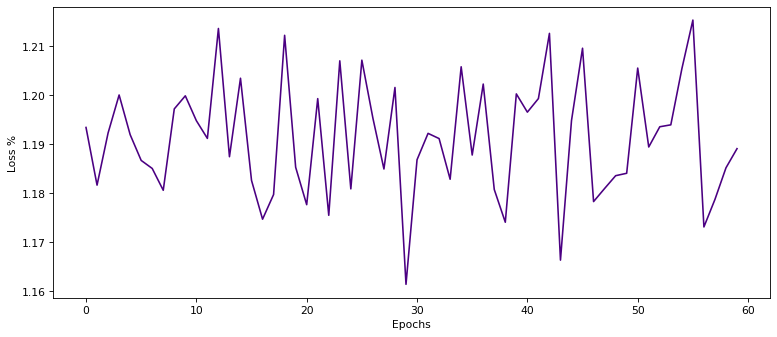

In [178]:
plt.figure(figsize=(12,5), dpi= 77)
plt.xlabel("Epochs")
plt.ylabel("Loss %")

plt.plot(loss_vals4, color = 'indigo')
plt.show()

> Al abandonar una clasificacion binaria y volverse un multiclass classification problem, hay algo de la arquitectura de la red que no nos permite abandonar la linealidad.\
El modelo no puede ir aprendiendo a lo largo del entrenamiento.